In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from pathlib import Path
from keras.preprocessing.text import Tokenizer
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from keras.metrics import Precision, Recall
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt

c:\Users\andrei\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting seeds

In [6]:
SEED = 12
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
data = pd.read_csv("dataset.csv", nrows=5000)

# Here is the first version with LSTM

In [3]:
data['review_text'] = data['review_text'].astype(str)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['review_text'])
sequences = tokenizer.texts_to_sequences(data['review_text'])

In [4]:
padded_sequences = pad_sequences(sequences, maxlen=max([len(seq) for seq in sequences]), padding='post')

In [5]:
labels = (data['review_score'] > 0).astype(int)
vocab_size = len(tokenizer.word_index) + 1

In [6]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max([len(seq) for seq in sequences])))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])
callbacks = [CSVLogger("./LSTM.csv", separator=",", append=False)]
history = model.fit(X_train, y_train, epochs=3, batch_size=128, validation_data=(X_test, y_test), callbacks = callbacks)

Epoch 1/3
32/32 [==============================] - 6s 113ms/step - loss: 0.3588 - accuracy: 0.8928 - precision: 0.9189 - recall: 0.9687 - val_loss: 0.3156 - val_accuracy: 0.9070 - val_precision: 0.9070 - val_recall: 1.0000
Epoch 2/3
32/32 [==============================] - 3s 92ms/step - loss: 0.2846 - accuracy: 0.9183 - precision: 0.9183 - recall: 1.0000 - val_loss: 0.3096 - val_accuracy: 0.9070 - val_precision: 0.9070 - val_recall: 1.0000
Epoch 3/3
32/32 [==============================] - 3s 108ms/step - loss: 0.2836 - accuracy: 0.9185 - precision: 0.9185 - recall: 1.0000 - val_loss: 0.3120 - val_accuracy: 0.9070 - val_precision: 0.9070 - val_recall: 1.0000


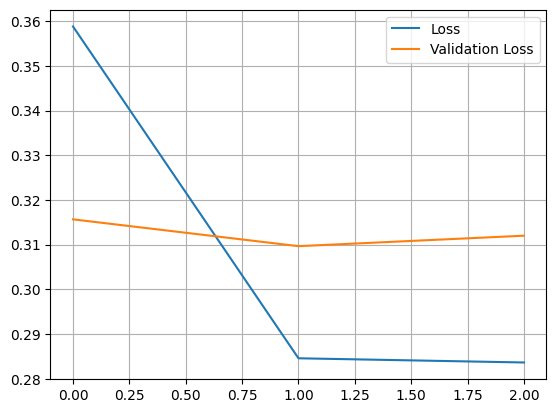

In [7]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

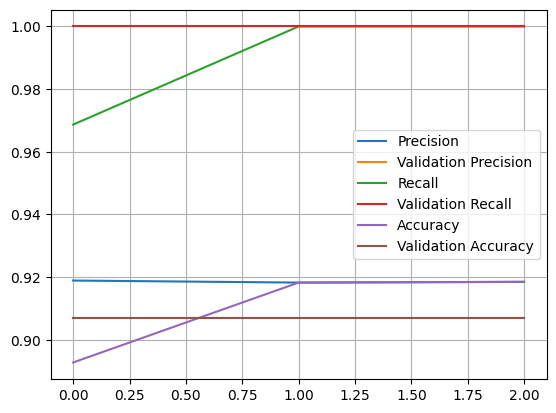

In [9]:
plt.plot(history.history["precision"], label="Precision")
plt.plot(history.history["val_precision"], label="Validation Precision")
plt.plot(history.history["recall"], label="Recall")
plt.plot(history.history["val_recall"], label="Validation Recall")
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: ', accuracy)

f1 = f1_score(y_test, y_pred)
print('F1 Score: ', f1)

# The BERT version using uncased, base pretrained BERT

In [3]:
X = []
y = []
# for review_text in data['review_text']:
#     if isinstance(review_text, str):
#         X.append(review_text)

for row in data.iterrows():
    if isinstance(row[1]['review_text'], str):
        X.append(row[1]['review_text'])
        y.append(row[1]['review_score'] > 0)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Tokenize input texts
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = bert_tokenizer(list(X_train), padding=True, truncation=True, max_length=150, return_tensors='tf')
test_encodings = bert_tokenizer(list(X_test), padding=True, truncation=True, max_length=150, return_tensors='tf')
# test_encodings = bert_tokenizer([preprocessing(text) for text in X_test], padding=True, truncation=True, max_length=150, return_tensors='tf')

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(len(X_train)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(16)

In [7]:
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
bert_model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
9984/9984 [==============================] - 2614s 260ms/step - loss: 0.1662 - accuracy: 0.9349 - val_loss: 0.1671 - val_accuracy: 0.9368
Epoch 2/5
9984/9984 [==============================] - 3839s 384ms/step - loss: 0.1332 - accuracy: 0.9485 - val_loss: 0.1552 - val_accuracy: 0.9369
Epoch 3/5
9984/9984 [==============================] - 2421s 242ms/step - loss: 0.1138 - accuracy: 0.9573 - val_loss: 0.2170 - val_accuracy: 0.9343
Epoch 4/5
9984/9984 [==============================] - 2562s 257ms/step - loss: 0.3025 - accuracy: 0.9052 - val_loss: 0.2942 - val_accuracy: 0.9011
Epoch 5/5
9984/9984 [==============================] - 2518s 252ms/step - loss: 0.3197 - accuracy: 0.9023 - val_loss: 0.3276 - val_accuracy: 0.9002


In [9]:
y_pred = bert_model.predict(test_dataset)[0]
y_pred_labels = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_labels))

2496/2496 [==============================] - 221s 87ms/step
              precision    recall  f1-score   support

       False       0.00      0.00      0.00      3984
        True       0.90      1.00      0.95     35950

    accuracy                           0.90     39934
   macro avg       0.45      0.50      0.47     39934
weighted avg       0.81      0.90      0.85     39934



c:\Users\andrei\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andrei\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andrei\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## Creating a smaller dataset, that is balanced as well

In [14]:
positive_reviews = data[data['review_score'] > 0]
negative_reviews = data[data['review_score'] < 0]
positive_samples = positive_reviews.sample(20000, random_state=SEED)
negative_samples = negative_reviews.sample(20000, random_state=SEED)

new_data = pd.concat([positive_samples, negative_samples])

make new method setseeds

In [15]:
print(new_data)

         app_id                        app_name  \
5890515   50620                      Darksiders   
2989172  261030    The Walking Dead: Season Two   
6129820     620                        Portal 2   
41540    104900                  ORION: Prelude   
551933   203770               Crusader Kings II   
...         ...                             ...   
1324107  221100                            DayZ   
5295431  405640                     Pony Island   
760703   208650          Batman™: Arkham Knight   
4803902  369200                             NaN   
3956315  310880  Basketball Pro Management 2015   

                                               review_text  review_score  \
5890515  A Great game but nothing compared to Darksider...             1   
2989172  I don't really write reviews for games but, I ...             1   
6129820  Portal 2 is the greatest game i have ever play...             1   
41540    This is a game that I recomend greatly due to ...             1   
551933 

# The BERT version 2 using uncased, base pretrained BERT, but on smaller dataset

In [4]:
X = []
y = []
# for review_text in data['review_text']:
#     if isinstance(review_text, str):
#         X.append(review_text)

for row in new_data.iterrows():
    if isinstance(row[1]['review_text'], str):
        X.append(row[1]['review_text'])
        y.append(row[1]['review_score'] > 0)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [6]:
# Tokenize input texts
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = bert_tokenizer(list(X_train), padding="max_length", truncation=True, max_length=20, return_tensors='tf')
test_encodings = bert_tokenizer(list(X_test), padding="max_length", truncation=True, max_length=20, return_tensors='tf')

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(len(X_train)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(16)

In [8]:
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
bert_model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
1999/1999 [==============================] - 802s 393ms/step - loss: 0.3932 - accuracy: 0.8054 - val_loss: 0.3620 - val_accuracy: 0.8197
Epoch 2/5
  22/1999 [..............................] - ETA: 33:56 - loss: 0.2880 - accuracy: 0.8438

KeyboardInterrupt: 

In [11]:
y_pred = bert_model.predict(test_dataset)[0]
y_pred_labels = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_labels))

4/4 [==============================] - 3s 64ms/step
              precision    recall  f1-score   support

       False       1.00      0.62      0.76        26
        True       0.71      1.00      0.83        25

    accuracy                           0.80        51
   macro avg       0.86      0.81      0.80        51
weighted avg       0.86      0.80      0.80        51

